In [2]:
import numpy as np
import pandas as pd
import os
from os.path import isdir, join
from pathlib import Path

In [3]:
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

In [4]:
from google.colab import files
uploaded = files.upload()

Saving data_audio.zip to data_audio.zip


In [6]:
import zipfile
import io
zf = zipfile.ZipFile(io.BytesIO(uploaded['data_audio.zip']), "r")
zf.extractall()

In [9]:
path='/content/data_audio/'
os.listdir(path)

['left', 'up', 'on', 'go', 'yes', 'off', 'no', 'down', 'stop', 'right']

In [10]:
example='00b01445_nohash_0.wav';
samples, sample_rate = librosa.load(str(path) +'left/'+ example, sr = 16000)

In [11]:
def log_specgram(audio, sample_rate, window_size=20,step_size=10, eps=1e-10):
    
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

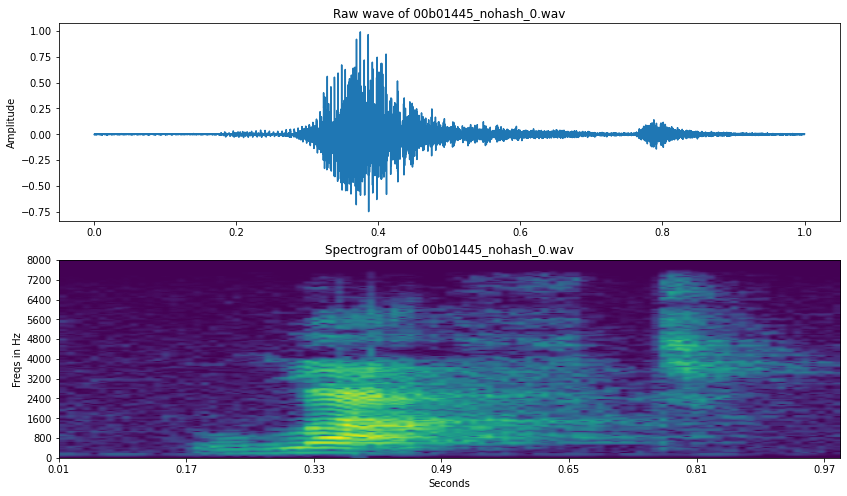

In [12]:
freqs, times, spectrogram = log_specgram(samples, sample_rate)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + example)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + example)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [13]:
import IPython.display as ipd
ipd.Audio(str(path) +'left/'+ example)

In [14]:
#resampling the current 16KHz to 8KHz
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

In [15]:
#labels which we want to keep

labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [16]:
#resampling all data to 8KHz and pre-processing

all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(path + '/'+ label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

yes
no
up
down
left
right
on
off
stop
go


In [17]:
all_wave=np.array(all_wave)
all_wave.shape

(21312, 8000)

In [18]:
#Converting labels
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder()
y=label.fit_transform(all_label)
classes= list(label.classes_)

In [19]:
#onr hot encoding labels
from keras.utils import np_utils
y=np_utils.to_categorical(y, num_classes=len(labels))
y.shape

(21312, 10)

In [20]:
#converting wav files to numerical vectors and reshaping to a 3D array

all_wave = np.array(all_wave).reshape(-1,8000,1)

In [21]:
#Spliting data into training and validation sets

from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=42,shuffle=True)

In [22]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(512, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 7988, 8)           112       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2662, 8)           0         
_________________________________________________________________
dropout (Dropout)            (None, 2662, 8)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2652, 16)          1424      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 884, 16)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 884, 16)          

In [23]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [26]:
history=model.fit(x_train, y_train,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
533/533 [==============================] - 11s 20ms/step - loss: 2.1189 - accuracy: 0.1906 - val_loss: 1.7682 - val_accuracy: 0.3106
Epoch 2/100
533/533 [==============================] - 10s 19ms/step - loss: 1.5563 - accuracy: 0.4047 - val_loss: 1.3064 - val_accuracy: 0.5250
Epoch 3/100
533/533 [==============================] - 10s 18ms/step - loss: 1.3000 - accuracy: 0.5235 - val_loss: 1.1701 - val_accuracy: 0.5536
Epoch 4/100
533/533 [==============================] - 10s 19ms/step - loss: 1.1543 - accuracy: 0.5836 - val_loss: 0.9733 - val_accuracy: 0.6606
Epoch 5/100
533/533 [==============================] - 10s 19ms/step - loss: 1.0415 - accuracy: 0.6338 - val_loss: 0.9861 - val_accuracy: 0.6463
Epoch 6/100
533/533 [==============================] - 10s 18ms/step - loss: 0.9382 - accuracy: 0.6753 - val_loss: 0.8499 - val_accuracy: 0.7124
Epoch 7/100
533/533 [==============================] - 10s 18ms/step - loss: 0.8611 - accuracy: 0.7040 - val_loss: 0.7701 - val_ac

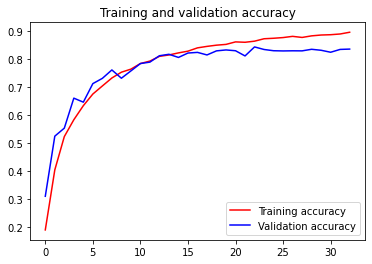

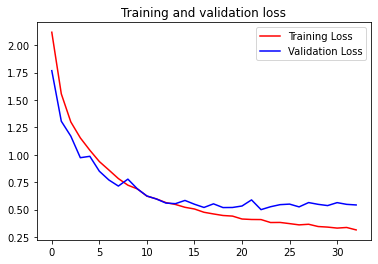

In [27]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()